<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/Rectifier_4phaseFullBridge_diode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Four-Phase Full-Brdige Diode Rectifier without Leakage Inductances</h1></b>

Dr. Bingsen Wang

3/30/2024
</center>

#Python Code
The Python code illustrates waveforms of the four-phase full-bridge diode rectifier.

<ipython-input-34-6c48082224d1>:282: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


0


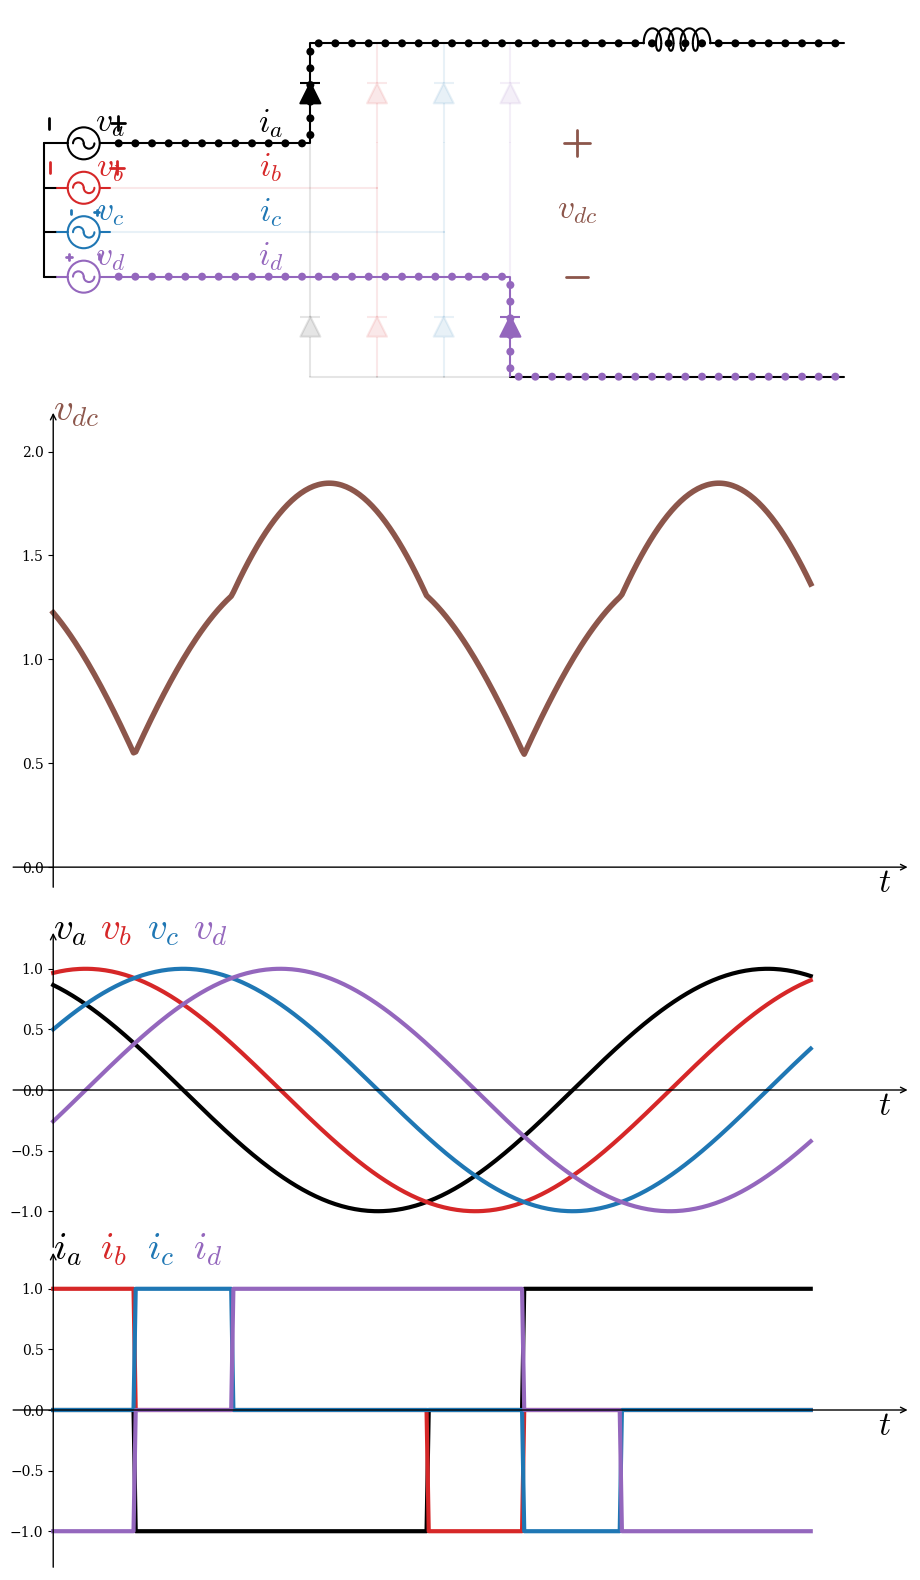

In [ ]:
import matplotlib
from os import linesep
import numpy as np
from numpy import linspace,cos,sin,pi,heaviside,fft,array,sqrt
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, to_hex, to_rgb
from matplotlib.path import Path
import matplotlib.patches as mp
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc,transforms
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#modulation functions
def mf(t,f,phi):
  mt = []
  for k in range(4):
    mt.append(cos(2*pi*f*t+phi - k*pi/2))
  return mt

#switching functions for the high-side diodes
def hh(mt):
  ht = []
  for k in range(4):
    ht.append(heaviside(mt[k]-mt[(k+1)%4],0)*heaviside(mt[k]-mt[(k+2)%4],0)*heaviside(mt[k]-mt[(k+3)%4],0))
  return ht

#switching functions for the low-side diodes
def hl(mt):
  ht = []
  for k in range(4):
    ht.append(heaviside(-mt[k]+mt[(k+1)%4],0)*heaviside(-mt[k]+mt[(k+2)%4],0)*heaviside(-mt[k]+mt[(k+3)%4],0))
  return ht

#ac current
def iac(t,f,phi,tc,hht,hlt):
  i = [] #high side current
  for k in range(4):
    i.append(hht[k] - hlt[k])
  return i

#dc voltage
def vdc(t,f,phi,tc,hht,hlt):
  vh = 0
  vl = 0
  for k in range(4):
    vh += hht[k]*mf(t,f,phi)[k]
    vl += hlt[k]*mf(t,f,phi)[k]
  return vh-vl

#draw diode symbol
def drawDiode(ax,x0,y0,h,theta,lw,color):
  codes=[Path.MOVETO,Path.LINETO]
  p1=mp.PathPatch(Path([(x0,y0),(x0,y0+h*0.4), (x0,y0+h*0.6),(x0,y0+h)],
                       codes+codes))
  p2=mp.PathPatch(Path([(x0-h*0.1,y0+h*0.6),(x0+h*0.1,y0+h*0.6)],
                       codes)) #cathode
  p3=mp.PathPatch(Path([(x0,y0+h*0.6),(x0-h*0.1,y0+h*0.4),(x0+h*0.1,y0+h*0.4),(x0,y0+h*0.6)],
                       [Path.MOVETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY])) #anode
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  kwargs=dict({'ec':color,'fc':['none','none',color],'lw':lw,'transform':rot})
  ax.add_collection(PatchCollection([p1,p2,p3],**kwargs))
  return

#draw inductor symbol
def drawInductor(ax,x0,y0,n,h,w,theta,lw,color):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  w= w/(0.7*n+0.3)#width of larger coil
  plg, psm = ([],[]) #the half coil with larger curvature
  codes=[Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]
  verts=[(x0,y0),(x0,y0+0.4*h),(x0+w,y0+0.4*h),(x0+w,y0)]
  for k in range(n):
    if k==0:
      plg.append(mp.PathPatch(Path(verts,codes)))
    else:
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0+0.4*h),
                (x0+(0.7*k+1)*w,y0+0.4*h),(x0+(0.7*k+1)*w,y0)], codes)
      plg.append(mp.PathPatch(p))
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0-0.2*h),
                (x0+(0.7*k+0.3)*w,y0-0.2*h),(x0+(0.7*k+0.3)*w,y0)], codes)
      psm.append(mp.PathPatch(p))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(np.concatenate((plg,psm)),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return


#draw ac voltage source symbol
def drawVoltSourceAc(ax,x0,y0,h,theta,lw,color):
  """ x0,y0: top or left end of the voltage source lead
  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical"""
  ps=[] # container of the zig-zags
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  p = Path([(x0,y0),(x0+.2*h,y0),(x0+.8*h,y0),(x0+h,y0)],codes)
  ps.append(mp.PathPatch(p))
  ps.append(mp.Circle((x0+.5*h,y0),.3*h))
  ps.append(mp.Arc((x0+.4*h,y0),.2*h,.2*h,theta2=180))
  ps.append(mp.Arc((x0+.6*h,y0),.2*h,.2*h,theta1=180))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(ps,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw the +/- voltage polarity with variable distance/color
def drawVoltSign(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center between "+" and "-"
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p = Path([(x0-0.5*h,y0-0.1*h),(x0-0.5*h,y0+0.1*h),(x0-0.6*h,y0),(x0-0.4*h,y0),
            (x0+0.5*h, y0-0.08*h),(x0+0.5*h, y0+0.08*h)],
           [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,
            Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  return

#combine rgb colors with weights
def combine_rgb_values(d):
  r,g,b=0,0,0
  for k in range(len(d)):
    r += d[k][0][0]*d[k][1]
    g += d[k][0][1]*d[k][1]
    b += d[k][0][2]*d[k][1]
  return (r,g,b)

#moving dots for current flow, only works for horizontal and vertical lines
def drawMovingDots(ax,path,space,n_steps,nth_step,rdot,color):
  i = 0
  dx0 = path[1][0] - path[0][0]
  dy0 = path[1][1] - path[0][1]
  x0 = path[0][0] + nth_step*space/n_steps*(2*heaviside(dx0,0.5)-1)
  y0 = path[0][1] + nth_step*space/n_steps*(2*heaviside(dy0,0.5)-1)
  while i<len(path)-1:
    dx = path[i+1][0] - path[i][0]
    dy = path[i+1][1] - path[i][1]
    ax.add_patch(mp.Circle([x0,y0],radius=rdot,fc=color))
    x0 += space*(2*heaviside(dx,0.5)-1)
    y0 += space*(2*heaviside(dy,0.5)-1)
    if (path[i+1][0] - x0)*dx < 0:
      if i+2<len(path):
        dy1 = path[i+2][1] - path[i+1][1]
      else:
        dy1 = 0
      y0 = path[i+1][1] + abs(x0 - path[i+1][0])*(2*heaviside(dy1,0.5)-1)
      x0 = path[i+1][0]
      i += 1
    elif (path[i+1][1]-y0)*dy < 0:
      if i+2<len(path):
        dx1 = path[i+2][0] - path[i+1][0]
      else:
        dx1 = 0
      x0 = path[i+1][0] + abs(y0 - path[i+1][1])*(2*heaviside(dx1,0.5)-1)
      y0 = path[i+1][1]
      i += 1
  return

#draw non-animated parts of the circuitry
def drawRectifierNa(ax,lw,clst,txlst):
  args = dict({'lw':lw,'capstyle':
               'round', 'fc':'None'})
  args1=  dict({'size':24,'va':'center'})
  codes=[Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO]
  x = -5
  for k in range(4):
    p1 = Path([(x,1-k*2/3), (x+.2,1-k*2/3)], codes[0:2])
    ax.add_patch(mp.PathPatch(p1,**args))
    drawVoltSourceAc(ax,x+.2,1-k*2/3,.8,0,lw,clst[k+1])
    ax.text(x+1,1.3-k*2/3, txlst[1][0][k],color=clst[1+k],ha='center',**args1) #va,b,c
    ax.text(x+3.4,1.3-k*2/3, txlst[2][0][k],color=clst[1+k],ha='center',**args1) #ia,b,c
  p2 = Path([(x+7,2.5), (x+9,2.5), (x+10,2.5), (x+12,2.5)],
            codes[0:2]+codes[0:2]) #positive dc rail
  p3 = Path([(x+7,-2.5),(x+12,-2.5)], codes[0:2]) #negative dc rail
  p4 = Path([(x,1), (x,-1)], codes[0:2]) #source neutral vertical
  ax.add_patch(mp.PathPatch(p2,**args))
  ax.add_patch(mp.PathPatch(p3,**args))
  ax.add_patch(mp.PathPatch(p4,**args))
  drawInductor(ax,x+9,2.5,5,.75,1,0,lw,'k') #dc inductor
  ax.text(x+8,0,txlst[0][0],color=clst[0],ha='center',**args1) #vdc
  return

#draw animated parts of the circuitry
def drawRectifierAnim(ax,i_ani,iht,ilt,vac,vdc,lw,clst):
  x=-5
  args = dict({'lw':lw,'capstyle':'round', 'fc':'None'})
  codes=[Path.MOVETO,Path.LINETO,Path.LINETO]
  for k in range(4):
    drawDiode(ax,x+4+k,1,1.5,0,lw,to_rgba(clst[1+k],max(iht[k],0.1))) #high-side
    drawDiode(ax,x+4+k,-2.5,1.5,0,lw,to_rgba(clst[1+k],max(ilt[k],0.1))) #low-side
    pp = Path([(x+4+k,1),(x+4+k,1-k*2/3)],codes[0:2])#vertical lines in bridge
    pn = Path([(x+4+k,-1),(x+4+k,1-k*2/3)],codes[0:2])#vertical lines in bridge
    p2 = Path([(x+1,1-k*2/3), (x+4+k,1-k*2/3)], codes[0:2]) #source to bridge
    ax.add_patch(mp.PathPatch(p2,color=to_rgba(clst[1+k],max(ilt[k],iht[k],0.1)),**args))
    ax.add_patch(mp.PathPatch(pp,color=to_rgba(clst[1+k],max(iht[k],0.1)),**args))
    ax.add_patch(mp.PathPatch(pn,color=to_rgba(clst[1+k],max(ilt[k],0.1)),**args))
    drawVoltSign(ax,x+.6,1.3-k*2/3,1.1*vac[k],180,2,clst[k+1]) #va sign
    if iht[k]>0:
      p_points = [[x+1,1-k*2/3],[x+4+k,1-k*2/3],[x+4+k,2.5],[x+12,2.5]]
      drawMovingDots(ax,p_points,0.25,20,i_ani%20,.06*iht[k],clst[1+k])
    if ilt[k]>0:
      n_points = [[x+1,1-k*2/3],[x+4+k,1-k*2/3],[x+4+k,-2.5],[x+12,-2.5]]
      drawMovingDots(ax,n_points[::-1],0.25,20,i_ani%20,.06*ilt[k],clst[1+k])
  p3 = Path([(x+4,2.5), (x+5,2.5)], codes[0:2]) #horizontal pos-ab
  p4 = Path([(x+5,2.5), (x+6,2.5)], codes[0:2]) #horizonatal pos-bc
  p5 = Path([(x+6,2.5), (x+7,2.5)], codes[0:2]) #horizonatal pos-cd
  p6 = Path([(x+4,-2.5), (x+5,-2.5)], codes[0:2]) #horizontal neg-ab
  p7 = Path([(x+5,-2.5), (x+6,-2.5)], codes[0:2]) #horizonatal neg-bc
  p8 = Path([(x+6,-2.5), (x+7,-2.5)], codes[0:2]) #horizonatal neg-cd
  ax.add_patch(mp.PathPatch(p3,color=to_rgba('k',max(iht[0],0.1)),**args))
  ax.add_patch(mp.PathPatch(p4,color=to_rgba('k',max(iht[0]+iht[1],0.1)),**args))
  ax.add_patch(mp.PathPatch(p5,color=to_rgba('k',max(iht[0]+iht[1]+iht[2],0.1)),**args))
  ax.add_patch(mp.PathPatch(p6,color=to_rgba('k',max(ilt[0],0.1)),**args))
  ax.add_patch(mp.PathPatch(p7,color=to_rgba('k',max(ilt[0]+ilt[1],0.1)),**args))
  ax.add_patch(mp.PathPatch(p8,color=to_rgba('k',max(ilt[0]+ilt[1]+ilt[2],0.1)),**args))
  drawVoltSign(ax,x+8,0,1.5*vdc,-90,2,clst[0]) #vdc sign
  return

#parameters
f=1
Nf = 360
t=linspace(0,1,Nf)
tmax = max(t)
phi = 30*pi/180
Tc = 10/(360*f)#communtation interval
mt = mf(t,f,phi) #time domain modulation functions
hht = hh(mt)
hlt = hl(mt)
iht = hht #high-side currents
ilt = hlt #low-side currents
iact = iac(t,f,phi,Tc,hht,hlt) #ac current
vdct = vdc(t,f,phi,Tc,hht,hlt) #dc voltage
#set up figures
fig = plt.figure(figsize=(9,16)) #overall plot area
km = 1.1 # margin
ax_frame = [[(0,.725 , 1, .25),[-5.5,8],[-3,3]], #circuit diagram
            [(0,.725 , 1, .25),[-5.5,8],[-3,3]], #animated circuit
            [(0, .425 , 1, .3),[-.05*km,1*km],[-.1*km,2*km]], #v_dc
            [(0,.2 , 1, .2),[-.05*km,1*km],[-1.2*km,1.2*km]], #v_ac
            [(0,0 , 1, .2),[-.05*km,1*km],[-1.2*km,1.2*km]], #v_ac
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lst=[] #axis list or the list of subplots
ax_lbl=[
        ['$v_{dc}$', '$t$'],
        [['$v_{a}$','$v_{b}$','$v_{c}$','$v_{d}$'], '$t$'],
        [['$i_{a}$','$i_{b}$','$i_{c}$','$i_{d}$'], '$t$'],
        ] #variables for yx axes of each subplot
clst=['tab:brown','k','tab:red','tab:blue','tab:purple'] #list of colors used for plots
text_tls = [] #place holder for titles of each plot updated during animation

#draw axes and label them for each subplot and setup the plot lines
lines = [] #array containing all the line segments
for k in range(len(ax_frame)):
  ax=fig.add_axes(ax_frame[k][0],xlim=ax_frame[k][1], ylim=ax_frame[k][2],
                  fc='none') #remove frame face color
  if k<2:
    ax.axis('off') #turn the first 2 axes for circuit digram completely off
  else: #the rest axes
    ax.spines[:].set_visible(False) #set all spines off
    ax.spines['left'].set_position(('data', 0)) #set spines to cross zero
    ax.set_xticks([]) #set x-axis ticks off
    xmin,xmax,ymin,ymax=np.concatenate((ax_frame[k][1],ax_frame[k][2]))
    ax.annotate("", xy=(xmax, 0), xytext=(xmin, 0),
          arrowprops=dict(arrowstyle="->")) #draw x-axis with arrow
    ax.annotate("", xy=(0,ymax), xytext=(0,ymin),
          arrowprops=dict(arrowstyle="->")) #draw y-axis with arrow
    ax.text(xmax-0.025,0,ax_lbl[k-2][-1],
            size=24,va='top',ha='right',color='k') #label x axis of subplot
    if k==2:
      ax.text(0,ymax,ax_lbl[0][0],size=28,va='center',color=clst[k-2])
      lines.append(ax.plot([],[],color=clst[k-2],lw=4)[0])
    else:
      for kk in range(len(ax_lbl[k-2][0])):
        ax.text(kk*0.06,ymax,ax_lbl[k-2][0][kk],size=28,va='center',color=clst[kk+1])
        lines.append(ax.plot([],[],color=clst[1+kk],lw=3)[0])

  ax_lst.append(ax)
fig.tight_layout()


# animation function. This is called sequentially
def animate(i):
  print(i) #for monitoring
  lines[0].set_data(t[0:i]/tmax,vdct[0:i])
  for k in range(4):
    lines[1+k].set_data(t[0:i]/tmax,mt[k][0:i])
    # lines[4+k].set_data(t[0:i]/tmax,ilt[k][0:i])
    lines[5+k].set_data(t[0:i]/tmax,iact[k][0:i])

  ax_lst[1].clear()
  ax_lst[1].set_xlim(ax_frame[1][1])
  ax_lst[1].set_ylim(ax_frame[1][2])
  ax_lst[1].axis('off')
  drawRectifierAnim(ax_lst[1],i,array(iht)[:,i],array(ilt)[:,i],array(mt)[:,i],vdct[i],1.5,clst)
  return

drawRectifierNa(ax_lst[0],1.5,clst,ax_lbl)
anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
writervideo = animation.FFMpegWriter(fps=30)
anim.save('rectifier_4ph.mp4', writer=writervideo,dpi = 240)